# Training and Evaluation of Logistic Regression on Encrypted Data
SOURCE: https://github.com/OpenMined/TenSEAL/blob/main/tutorials/Tutorial%201%20-%20Training%20and%20Evaluation%20of%20Logistic%20Regression%20on%20Encrypted%20Data.ipynb

In [3]:
import torch
import tenseal as ts
import pandas as pd
import random
from time import time

# those are optional and are not necessary for training
import numpy as np
import matplotlib.pyplot as plt

In [4]:
torch.random.manual_seed(73)
random.seed(73)


def split_train_test(x, y, test_ratio=0.3):
    idxs = [i for i in range(len(x))]
    random.shuffle(idxs)
    # delimiter between test and train data
    delim = int(len(x) * test_ratio)
    test_idxs, train_idxs = idxs[:delim], idxs[delim:]
    return x[train_idxs], y[train_idxs], x[test_idxs], y[test_idxs]


def heart_disease_data():
    data = pd.read_csv("../../../data/he_data/framingham.csv")
    # drop rows with missing values
    data = data.dropna()
    # drop some features
    data = data.drop(columns=["education", "currentSmoker", "BPMeds", "diabetes", "diaBP", "BMI"])
    # balance data
    grouped = data.groupby('TenYearCHD')
    data = grouped.apply(lambda x: x.sample(grouped.size().min(), random_state=73).reset_index(drop=True))
    # extract labels
    y = torch.tensor(data["TenYearCHD"].values).float().unsqueeze(1)
    data = data.drop("TenYearCHD", 'columns')
    # standardize data
    data = (data - data.mean()) / data.std()
    x = torch.tensor(data.values).float()
    return split_train_test(x, y)


def random_data(m=1024, n=2):
    # data separable by the line `y = x`
    x_train = torch.randn(m, n)
    x_test = torch.randn(m // 2, n)
    y_train = (x_train[:, 0] >= x_train[:, 1]).float().unsqueeze(0).t()
    y_test = (x_test[:, 0] >= x_test[:, 1]).float().unsqueeze(0).t()
    return x_train, y_train, x_test, y_test


# You can use whatever data you want without modification to the tutorial
# x_train, y_train, x_test, y_test = random_data()
x_train, y_train, x_test, y_test = heart_disease_data()

print("############# Data summary #############")
print(f"x_train has shape: {x_train.shape}")
print(f"y_train has shape: {y_train.shape}")
print(f"x_test has shape: {x_test.shape}")
print(f"y_test has shape: {y_test.shape}")
print("#######################################")

############# Data summary #############
x_train has shape: torch.Size([780, 9])
y_train has shape: torch.Size([780, 1])
x_test has shape: torch.Size([334, 9])
y_test has shape: torch.Size([334, 1])
#######################################


<ipython-input-4-ac70090a44f4>:25: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data = data.drop("TenYearCHD", 'columns')


## Training a Logistic Regression Model

In [6]:
class LR(torch.nn.Module):

    def __init__(self, n_features):
        super(LR, self).__init__()
        self.lr = torch.nn.Linear(n_features, 1)
        
    def forward(self, x):
        out = torch.sigmoid(self.lr(x))
        return out

In [7]:
n_features = x_train.shape[1]
model = LR(n_features)
# use gradient descent with a learning_rate=1
optim = torch.optim.SGD(model.parameters(), lr=1)
# use Binary Cross Entropy Loss
criterion = torch.nn.BCELoss()

In [8]:
# define the number of epochs for both plain and encrypted training
EPOCHS = 50

def train(model, optim, criterion, x, y, epochs=EPOCHS):
    for e in range(1, epochs + 1):
        optim.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optim.step()
        print(f"Loss at epoch {e}: {loss.data}")
    return model

model = train(model, optim, criterion, x_train, y_train)

Loss at epoch 1: 0.8504331707954407
Loss at epoch 2: 0.6863385438919067
Loss at epoch 3: 0.6358115077018738
Loss at epoch 4: 0.6193529367446899
Loss at epoch 5: 0.6124349236488342
Loss at epoch 6: 0.6089244484901428
Loss at epoch 7: 0.606925904750824
Loss at epoch 8: 0.6057039499282837
Loss at epoch 9: 0.6049202680587769
Loss at epoch 10: 0.604399561882019
Loss at epoch 11: 0.6040432453155518
Loss at epoch 12: 0.6037929654121399
Loss at epoch 13: 0.6036127209663391
Loss at epoch 14: 0.6034799814224243
Loss at epoch 15: 0.603380024433136
Loss at epoch 16: 0.6033029556274414
Loss at epoch 17: 0.6032425165176392
Loss at epoch 18: 0.6031941175460815
Loss at epoch 19: 0.603154718875885
Loss at epoch 20: 0.6031221151351929
Loss at epoch 21: 0.603094756603241
Loss at epoch 22: 0.603071391582489
Loss at epoch 23: 0.6030514240264893
Loss at epoch 24: 0.6030339002609253
Loss at epoch 25: 0.603018581867218
Loss at epoch 26: 0.6030049324035645
Loss at epoch 27: 0.6029927134513855
Loss at epoch 28:

In [9]:
def accuracy(model, x, y):
    out = model(x)
    correct = torch.abs(y - out) < 0.5
    return correct.float().mean()

plain_accuracy = accuracy(model, x_test, y_test)
print(f"Accuracy on plain test_set: {plain_accuracy}")

Accuracy on plain test_set: 0.703592836856842


## Encrypted Evaluation

In [10]:
class EncryptedLR:
    
    def __init__(self, torch_lr):
        # TenSEAL processes lists and not torch tensors,
        # so we take out the parameters from the PyTorch model
        self.weight = torch_lr.lr.weight.data.tolist()[0]
        self.bias = torch_lr.lr.bias.data.tolist()
        
    def forward(self, enc_x):
        # We don't need to perform sigmoid as this model
        # will only be used for evaluation, and the label
        # can be deduced without applying sigmoid
        enc_out = enc_x.dot(self.weight) + self.bias
        return enc_out
    
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)
        
    ################################################
    ## You can use the functions below to perform ##
    ## the evaluation with an encrypted model     ##
    ################################################
    
    def encrypt(self, context):
        self.weight = ts.ckks_vector(context, self.weight)
        self.bias = ts.ckks_vector(context, self.bias)
        
    def decrypt(self, context):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()
        

eelr = EncryptedLR(model)

### Create TenSEAL contex 
for specifying the scheme and parameters we are going to use.

In [11]:

# parameters
poly_mod_degree = 4096
coeff_mod_bit_sizes = [40, 20, 40]
# create TenSEALContext
ctx_eval = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
# scale of ciphertext to use
ctx_eval.global_scale = 2 ** 20
# this key is needed for doing dot-product operations
ctx_eval.generate_galois_keys()

In [12]:
t_start = time()
enc_x_test = [ts.ckks_vector(ctx_eval, x.tolist()) for x in x_test]
t_end = time()
print(f"Encryption of the test-set took {int(t_end - t_start)} seconds")

Encryption of the test-set took 1 seconds


In [13]:
def encrypted_evaluation(model, enc_x_test, y_test):
    t_start = time()
    
    correct = 0
    for enc_x, y in zip(enc_x_test, y_test):
        # encrypted evaluation
        enc_out = model(enc_x)
        # plain comparaison
        out = enc_out.decrypt()
        out = torch.tensor(out)
        out = torch.sigmoid(out)
        if torch.abs(out - y) < 0.5:
            correct += 1
    
    t_end = time()
    print(f"Evaluated test_set of {len(x_test)} entries in {int(t_end - t_start)} seconds")
    print(f"Accuracy: {correct}/{len(x_test)} = {correct / len(x_test)}")
    return correct / len(x_test)
    

encrypted_accuracy = encrypted_evaluation(eelr, enc_x_test, y_test)
diff_accuracy = plain_accuracy - encrypted_accuracy
print(f"Difference between plain and encrypted accuracies: {diff_accuracy}")
if diff_accuracy < 0:
    print("Oh! We got a better accuracy on the encrypted test-set! The noise was on our side...")

Evaluated test_set of 334 entries in 1 seconds
Accuracy: 234/334 = 0.7005988023952096
Difference between plain and encrypted accuracies: 0.002994060516357422


## Training an Encrypted Logistic Regression Model on Encrypted Data

In [14]:
class EncryptedLR:
    
    def __init__(self, torch_lr):
        self.weight = torch_lr.lr.weight.data.tolist()[0]
        self.bias = torch_lr.lr.bias.data.tolist()
        # we accumulate gradients and counts the number of iterations
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0
        
    def forward(self, enc_x):
        enc_out = enc_x.dot(self.weight) + self.bias
        enc_out = EncryptedLR.sigmoid(enc_out)
        return enc_out
    
    def backward(self, enc_x, enc_out, enc_y):
        out_minus_y = (enc_out - enc_y)
        self._delta_w += enc_x * out_minus_y
        self._delta_b += out_minus_y
        self._count += 1
        
    def update_parameters(self):
        if self._count == 0:
            raise RuntimeError("You should at least run one forward iteration")
        # update weights
        # We use a small regularization term to keep the output
        # of the linear layer in the range of the sigmoid approximation
        self.weight -= self._delta_w * (1 / self._count) + self.weight * 0.05
        self.bias -= self._delta_b * (1 / self._count)
        # reset gradient accumulators and iterations count
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0
    
    @staticmethod
    def sigmoid(enc_x):
        # We use the polynomial approximation of degree 3
        # sigmoid(x) = 0.5 + 0.197 * x - 0.004 * x^3
        # from https://eprint.iacr.org/2018/462.pdf
        # which fits the function pretty well in the range [-5,5]
        return enc_x.polyval([0.5, 0.197, 0, -0.004])
    
    def plain_accuracy(self, x_test, y_test):
        # evaluate accuracy of the model on
        # the plain (x_test, y_test) dataset
        w = torch.tensor(self.weight)
        b = torch.tensor(self.bias)
        out = torch.sigmoid(x_test.matmul(w) + b).reshape(-1, 1)
        correct = torch.abs(y_test - out) < 0.5
        return correct.float().mean()    
    
    def encrypt(self, context):
        self.weight = ts.ckks_vector(context, self.weight)
        self.bias = ts.ckks_vector(context, self.bias)
        
    def decrypt(self):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()
        
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

In [15]:
# parameters
poly_mod_degree = 8192
coeff_mod_bit_sizes = [40, 21, 21, 21, 21, 21, 21, 40]
# create TenSEALContext
ctx_training = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
ctx_training.global_scale = 2 ** 21
ctx_training.generate_galois_keys()

In [16]:
t_start = time()
enc_x_train = [ts.ckks_vector(ctx_training, x.tolist()) for x in x_train]
enc_y_train = [ts.ckks_vector(ctx_training, y.tolist()) for y in y_train]
t_end = time()
print(f"Encryption of the training_set took {int(t_end - t_start)} seconds")

Encryption of the training_set took 18 seconds


Distribution on plain data:


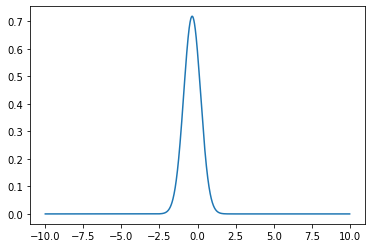

Distribution on encrypted data:


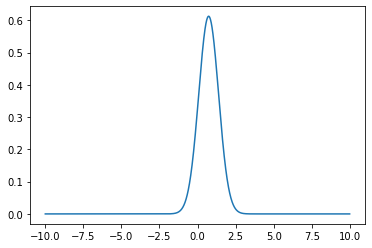

In [17]:
normal_dist = lambda x, mean, var: np.exp(- np.square(x - mean) / (2 * var)) / np.sqrt(2 * np.pi * var)

def plot_normal_dist(mean, var, rmin=-10, rmax=10):
    x = np.arange(rmin, rmax, 0.01)
    y = normal_dist(x, mean, var)
    fig = plt.plot(x, y)
    
# plain distribution
lr = LR(n_features)
data = lr.lr(x_test)
mean, var = map(float, [data.mean(), data.std() ** 2])
plot_normal_dist(mean, var)
print("Distribution on plain data:")
plt.show()

# encrypted distribution
def encrypted_out_distribution(eelr, enc_x_test):
    w = eelr.weight
    b = eelr.bias
    data = []
    for enc_x in enc_x_test:
        enc_out = enc_x.dot(w) + b
        data.append(enc_out.decrypt())
    data = torch.tensor(data)
    mean, var = map(float, [data.mean(), data.std() ** 2])
    plot_normal_dist(mean, var)
    print("Distribution on encrypted data:")
    plt.show()

eelr = EncryptedLR(lr)
eelr.encrypt(ctx_training)
encrypted_out_distribution(eelr, enc_x_train)

In [18]:
eelr = EncryptedLR(LR(n_features))
accuracy = eelr.plain_accuracy(x_test, y_test)
print(f"Accuracy at epoch #0 is {accuracy}")

times = []
for epoch in range(EPOCHS):
    eelr.encrypt(ctx_training)
    
    # if you want to keep an eye on the distribution to make sure
    # the function approxiamation is still working fine
    # WARNING: this operation is time consuming
    # encrypted_out_distribution(eelr, enc_x_train)
    
    t_start = time()
    for enc_x, enc_y in zip(enc_x_train, enc_y_train):
        enc_out = eelr.forward(enc_x)
        eelr.backward(enc_x, enc_out, enc_y)
    eelr.update_parameters()
    t_end = time()
    times.append(t_end - t_start)
    
    eelr.decrypt()
    accuracy = eelr.plain_accuracy(x_test, y_test)
    print(f"Accuracy at epoch #{epoch + 1} is {accuracy}")


print(f"\nAverage time per epoch: {int(sum(times) / len(times))} seconds")
print(f"Final accuracy is {accuracy}")

diff_accuracy = plain_accuracy - accuracy
print(f"Difference between plain and encrypted accuracies: {diff_accuracy}")
if diff_accuracy < 0:
    print("Oh! We got a better accuracy when training on encrypted data! The noise was on our side...")

Accuracy at epoch #0 is 0.523952066898346
Accuracy at epoch #1 is 0.6616766452789307
Accuracy at epoch #2 is 0.6646706461906433
Accuracy at epoch #3 is 0.6347305178642273
Accuracy at epoch #4 is 0.6377245783805847
Accuracy at epoch #5 is 0.6377245783805847
Accuracy at epoch #6 is 0.628742516040802
Accuracy at epoch #7 is 0.49700599908828735
Accuracy at epoch #8 is 0.49700599908828735
Accuracy at epoch #9 is 0.49700599908828735
Accuracy at epoch #10 is 0.5029940009117126
Accuracy at epoch #11 is 0.5029940009117126
Accuracy at epoch #12 is 0.49700599908828735
Accuracy at epoch #13 is 0.5029940009117126


KeyboardInterrupt: 